In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
%matplotlib inline
import re 
import math
import time

In [0]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [0]:
# import spacy
# # Need to load the large model to get the vectors
# import en_core_web_sm
# nlp = en_core_web_sm.load()

In [0]:
RANDOM_SEED = 123
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
import os
import pandas as pd

# read the text file and add the column names
read_file = pd.read_csv(r"/content/drive/My Drive/Colab Notebooks/Project/booksummaries.txt", sep='	', header=None)
read_file.columns = ['ID', 'm number', 'book name', 'author name', 'date', 'label', 'summary']

# clean data
read_file['label'] = read_file['label'].str.replace(r'/m/\S*\s', '')
read_file['label'] = read_file['label'].str.replace(r'{', '')
read_file['label'] = read_file['label'].str.replace(r'}', '')
read_file['label'] = read_file['label'].str.replace(r'}', '')
read_file['label'] = read_file['label'].str.replace(r'\\u00e0\s+clef', '')

# select columns
new_file = read_file.loc[:, ['book name', 'label', 'summary']]

#delete the columns with no labels
new_file.dropna(axis = 0, how = 'any', inplace = True)
new_file = new_file.iloc[:, [0, 2, 1]]

new_file = new_file.reset_index(drop=True)

#output data as csv
new_file.to_csv(r'/content/drive/My Drive/Colab Notebooks/Project/booksummries.csv', index=False)


In [7]:
new_file.head()

,book name,summary,label
0,Animal Farm,"Old Major, the old boar on the Manor Farm, ca...","""""Roman "", """"Satire"", """"Children's literature""..."
1,A Clockwork Orange,"Alex, a teenager living in near-future Englan...","""""Science Fiction"", """"Novella"", """"Speculative ..."
2,The Plague,The text of The Plague is divided into five p...,"""""Existentialism"", """"Fiction"", """"Absurdist fic..."
3,A Fire Upon the Deep,The novel posits that space around the Milky ...,"""""Hard science fiction"", """"Science Fiction"", ""..."
4,All Quiet on the Western Front,"The book tells the story of Paul Bäumer, a Ge...","""""War novel"", """"Roman """


In [0]:
def text_process(label_list):
    has_fiction = False
    has_spec_fiction = False
    has_novel = False
    has_spec_novel = False
    for i in range(len(label_list)):
        if 'novel' in label_list[i].lower():
            if 'novel' == label_list[i].lower():
                has_novel = True
            else:
                has_spec_novel = True
        if 'fiction' in label_list[i].lower():
            if 'fiction' == label_list[i].lower():
                has_fiction = True
            else:
                has_spec_fiction = True
        
    if has_spec_fiction and has_spec_novel:
        if has_fiction:
            label_list.remove('fiction')
        if has_novel:
            label_list.remove('novel')
    elif has_spec_fiction:
        if has_fiction:
            label_list.remove('fiction')
        if has_novel:
            label_list.remove('novel')
    elif has_spec_novel:
        if has_fiction:
            label_list.remove('fiction')
        if has_novel:
            label_list.remove('novel')
    elif has_fiction and has_novel:
        label_list.remove('fiction')
    return label_list

In [0]:
import re
for index in range(len(new_file['label'])):
    label = new_file['label'][index].replace('"', ''). lower()
    label_list = re.split(', ', label)  
    label_list = text_process(label_list)
    new_file.xs(index)['label']= label_list

In [0]:
#output data as csv
new_file.to_csv(r'./booksummries.csv', index=False)


In [11]:
new_file.tail()

,book name,summary,label
12836,The Third Lynx,The story starts with former government agent...,[science fiction]
12837,Remote Control,The series follows the character of Nick Ston...,"[thriller, fiction, suspense]"
12838,Transfer of Power,The reader first meets Rapp while he is doing...,"[thriller, fiction]"
12839,Decoded,The book follows very rough chronological ord...,[autobiography]
12840,Poor Folk,Makar Devushkin and Varvara Dobroselova are s...,"[epistolary novel, speculative fiction]"


In [12]:
categories = list(new_file['label'].values)
all_labels = [ word for labels in categories for word in labels]
counts = Counter(all_labels)
# for i in categories:
#     counts.append((i, new_file['label'][i].sum()))
df_stats = pd.DataFrame(counts.items(), columns=['labels', '#books'])
df_stats = df_stats.sort_values(by = '#books', ascending = False)
df_stats

,labels,#books
3,speculative fiction,4314
4,science fiction,2870
10,fantasy,2413
2,children's literature,2122
33,novel,1581
...,...,...
187,fable,1
188,bangsian fantasy,1
189,space western,1
194,fantastique,1


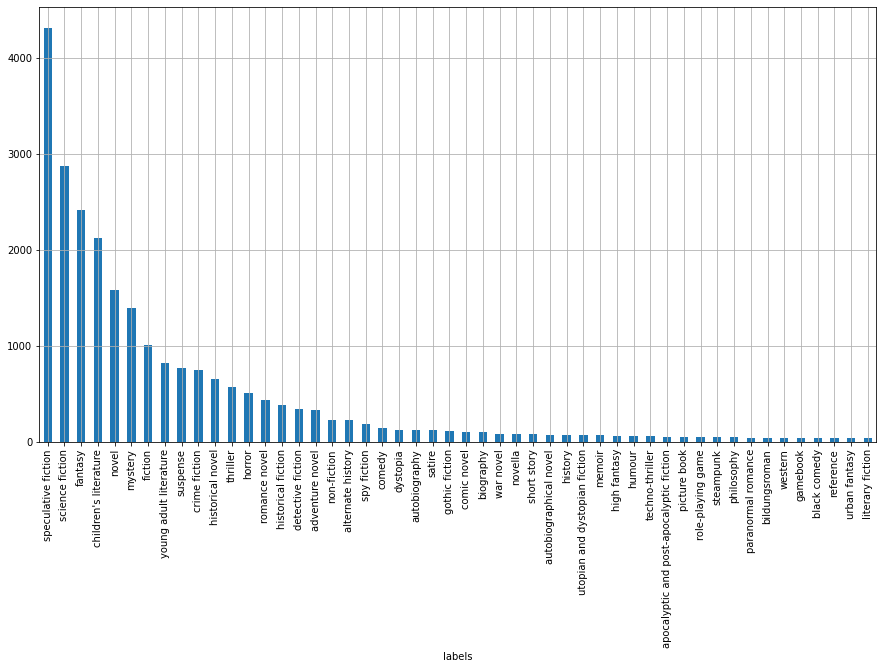

In [13]:
df_stats.iloc[:50, :].plot(x='labels', y='#books', kind='bar', legend=False, grid=True, figsize=(15, 8))

In [0]:
label_list = []
for index in range(len(new_file['label'])):
    object_label = new_file['label'][index]
    for l in object_label:
        if l not in label_list:
            label_list.append(l)

In [15]:
len(label_list)

227

In [0]:
one_hot = pd.DataFrame(np.zeros((12841, 227)), columns=label_list).astype(int)

In [0]:
for index in range(len(new_file['label'])):
    object_label = new_file['label'][index]
    for l in object_label:
        one_hot[l][index] = 1

In [18]:
one_hot

,roman,satire,children's literature,speculative fiction,science fiction,novella,utopian and dystopian fiction,existentialism,absurdist fiction,hard science fiction,fantasy,war novel,bildungsroman,religious text,picaresque novel,gothic fiction,fiction,horror,invasion literature,mystery,epistolary novel,parody,psychological novel,farce,philosophy,science,dystopia,detective fiction,suspense,historical fiction,adventure novel,humour,historical novel,novel,sea story,cyberpunk,business,non-fiction,economics,anthropology,...,fable,bangsian fantasy,space western,historical fantasy,edisonade,military history,sword and sorcery,fantastique,youth,photography,modernism,medieval romance,paranormal romance,bit lit,contemporary fantasy,urban fiction,collage,subterranean fiction,superhero fiction,heroic fantasy,marketing,colonial united states romance,creative nonfiction,low fantasy,light novel,police procedural,fairytale fantasy,indian chick lit,autobiographical comics,fictional crossover,encyclopedia,mashup,biopunk,popular culture,neuroscience,new york times best seller list,epic science fiction and fantasy,alien invasion,prose,pastiche
0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12836,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12837,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12838,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12839,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
from torchtext import data
from torchtext import datasets
import random

In [0]:
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)

VOCABULARY_SIZE = 20000
LEARNING_RATE = 1e-4
BATCH_SIZE = 128
NUM_EPOCHS = 15
DEVICE = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

EMBEDDING_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = 1

In [21]:
df = pd.concat([new_file['summary'], one_hot], axis=1)
df.head()

,summary,roman,satire,children's literature,speculative fiction,science fiction,novella,utopian and dystopian fiction,existentialism,absurdist fiction,hard science fiction,fantasy,war novel,bildungsroman,religious text,picaresque novel,gothic fiction,fiction,horror,invasion literature,mystery,epistolary novel,parody,psychological novel,farce,philosophy,science,dystopia,detective fiction,suspense,historical fiction,adventure novel,humour,historical novel,novel,sea story,cyberpunk,business,non-fiction,economics,...,fable,bangsian fantasy,space western,historical fantasy,edisonade,military history,sword and sorcery,fantastique,youth,photography,modernism,medieval romance,paranormal romance,bit lit,contemporary fantasy,urban fiction,collage,subterranean fiction,superhero fiction,heroic fantasy,marketing,colonial united states romance,creative nonfiction,low fantasy,light novel,police procedural,fairytale fantasy,indian chick lit,autobiographical comics,fictional crossover,encyclopedia,mashup,biopunk,popular culture,neuroscience,new york times best seller list,epic science fiction and fantasy,alien invasion,prose,pastiche
0,"Old Major, the old boar on the Manor Farm, ca...",1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Alex, a teenager living in near-future Englan...",0,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,The text of The Plague is divided into five p...,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,The novel posits that space around the Milky ...,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"The book tells the story of Paul Bäumer, a Ge...",1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
import operator
temp = df.iloc[:,1:]
number_of_labels={}
for label in temp:
  if label not in number_of_labels:
    number_of_labels[label] = len(temp[temp[label]==1])
sorted_label = sorted(number_of_labels.items(), key=operator.itemgetter(1))

In [23]:
sorted_label = sorted_label[len(sorted_label)-14:len(sorted_label)]
sorted_label

[('romance novel', 435),
 ('horror', 511),
 ('thriller', 568),
 ('historical novel', 654),
 ('crime fiction', 753),
 ('suspense', 765),
 ('young adult literature', 825),
 ('fiction', 1007),
 ('mystery', 1396),
 ('novel', 1581),
 ("children's literature", 2122),
 ('fantasy', 2413),
 ('science fiction', 2870),
 ('speculative fiction', 4314)]

In [24]:
keys = ['summary']
for tup in sorted_label:
  keys.append(tup[0])
keys

['summary',
 'romance novel',
 'horror',
 'thriller',
 'historical novel',
 'crime fiction',
 'suspense',
 'young adult literature',
 'fiction',
 'mystery',
 'novel',
 "children's literature",
 'fantasy',
 'science fiction',
 'speculative fiction']

In [25]:
df_new = df[keys]
df_new

,summary,romance novel,horror,thriller,historical novel,crime fiction,suspense,young adult literature,fiction,mystery,novel,children's literature,fantasy,science fiction,speculative fiction
0,"Old Major, the old boar on the Manor Farm, ca...",0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,"Alex, a teenager living in near-future Englan...",0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,The text of The Plague is divided into five p...,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,The novel posits that space around the Milky ...,0,0,0,0,0,0,0,0,0,0,0,1,1,1
4,"The book tells the story of Paul Bäumer, a Ge...",0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12836,The story starts with former government agent...,0,0,0,0,0,0,0,0,0,0,0,0,1,0
12837,The series follows the character of Nick Ston...,0,0,1,0,0,1,0,1,0,0,0,0,0,0
12838,The reader first meets Rapp while he is doing...,0,0,1,0,0,0,0,1,0,0,0,0,0,0
12839,The book follows very rough chronological ord...,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
df_new.to_csv(r'/content/drive/My Drive/Colab Notebooks/Project/revised_format.csv', index=False)
del df_new

In [0]:
TEXT = data.Field(sequential=True,
                  tokenize='spacy',
                  include_lengths=True) # necessary for packed_padded_sequence

LABEL = data.LabelField(dtype=torch.float)

In [0]:
fields = [('summaries', TEXT),
 ('historical fiction', LABEL),
 ('romance novel', LABEL),
 ('horror', LABEL),
 ('thriller', LABEL),
 ('historical novel', LABEL),
 ('crime fiction', LABEL),
 ('suspense', LABEL),
 ('young adult literature', LABEL),
 ('fiction', LABEL),
 ('mystery', LABEL),
 ('novel', LABEL),
 ("children's literature", LABEL),
 ('fantasy', LABEL),
 ('science fiction', LABEL),
 ]

dataset = data.TabularDataset(
    path="/content/drive/My Drive/Colab Notebooks/Project/revised_format.csv", format='csv',
    skip_header=True, fields=fields)

In [29]:
train_data, valid_data, test_data = dataset.split(
    split_ratio=[0.75, 0.05, 0.2],
    random_state=random.seed(RANDOM_SEED))

print(f'Num Train: {len(train_data)}')
print(f'Num Valid: {len(valid_data)}')
print(f'Num Test: {len(test_data)}')

Num Train: 9631
Num Valid: 2568
Num Test: 642


In [30]:
train_data[0].__dict__.keys()

dict_keys(['summaries', 'historical fiction', 'romance novel', 'horror', 'thriller', 'historical novel', 'crime fiction', 'suspense', 'young adult literature', 'fiction', 'mystery', 'novel', "children's literature", 'fantasy', 'science fiction'])

In [31]:
TEXT.build_vocab(train_data, max_size=VOCABULARY_SIZE)
LABEL.build_vocab(train_data)

print(f'Vocabulary size: {len(TEXT.vocab)}')
print(f'Number of classes: {len(LABEL.vocab)}')

Vocabulary size: 20002
Number of classes: 2


In [0]:
train_loader, valid_loader, test_loader = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE,
    sort_within_batch=True, # necessary for packed_padded_sequence
    sort_key=lambda x: len(x.summaries),
    device=DEVICE)

In [33]:
print('Train')
for batch in train_loader:
    print(f'Text matrix size: {batch.summaries[0].size()}')
    print(f'Target vector size: {batch.horror.size()}')
    break


Train
Text matrix size: torch.Size([268, 128])
Target vector size: torch.Size([128])


In [0]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_length):

        #[sentence len, batch size] => [sentence len, batch size, embedding size]
        embedded = self.embedding(text)
        
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, text_length)
        
        #[sentence len, batch size, embedding size] => 
        #  output: [sentence len, batch size, hidden size]
        #  hidden: [1, batch size, hidden size]
        packed_output, (hidden, cell) = self.rnn(packed)
        
        return self.fc(hidden.squeeze(0)).view(-1)

In [0]:
INPUT_DIM = len(TEXT.vocab)

torch.manual_seed(RANDOM_SEED)
model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [0]:
def compute_binary_accuracy(model, data_loader, device):
    model.eval()
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for batch_idx, batch_data in enumerate(data_loader):
            text, text_lengths = batch_data.summaries
            logits = model(text, text_lengths)
            predicted_labels = (torch.sigmoid(logits) > 0.5).long()
            num_examples += batch_data.summaries.size(0)
            correct_pred += (predicted_labels.long() == batch_data.summaries.long()).sum()
        return correct_pred.float()/num_examples * 100

In [0]:
import torch.nn.functional as F
for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, batch_data in enumerate(train_loader):
        
        text, text_lengths = batch_data.summaries
        
        ### FORWARD AND BACK PROP
        logits = model(text, text_lengths)

          
        dele = ['batch_size', 'dataset', 'fields', 'input_fields', 'target_fields', 'summaries']
        temp = batch_data.__dict__
        #classes = temp.keys()

        cost = None 
        for cl in temp:
           if cl not in dele:
               if cost is None:
                    cost =  F.binary_cross_entropy_with_logits(logits, temp[cl])
               else:
                   cost =  cost + F.binary_cross_entropy_with_logits(logits, temp[cl])
        cost = cost.mean()
           
        optimizer.zero_grad()
              
        cost.backward()
              
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
              
        ### LOGGING
        if not batch_idx % 1:
           print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                  f'Batch {batch_idx:03d}/{len(train_loader):03d} | '
                  f'Cost: {cost:.4f}')

    with torch.set_grad_enabled(False):
        print(f'training accuracy: '
              f'{compute_binary_accuracy(model, train_loader, DEVICE):.2f}%'
              f'\nvalid accuracy: '
              f'{compute_binary_accuracy(model, valid_loader, DEVICE):.2f}%')
        
    print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
    
print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')
print(f'Test accuracy: {compute_binary_accuracy(model, test_loader, DEVICE):.2f}%')